<a href="https://colab.research.google.com/github/thoid/CFD-with-NN/blob/main/Best_AC_position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import pickle



In [ ]:
VM = False

if VM:
  url = ''
else:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  url ='/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
from keras.models import load_model

model_summer = load_model(url + 'Research_Project/Summer/Model/model_summer_N.h5')
with open(url + 'Research_Project/Summer/History/history_summer_N.pkl', 'rb') as f:
    history_summer = pickle.load(f)

model_winter = load_model(url + 'Research_Project/Winter/Model/model_Winter_N.h5')
with open(url + 'Research_Project/Winter/History/history_Winter_N.pkl', 'rb') as f:
    history_winter = pickle.load(f)

#Sol Air Temperature Calculation

In [ ]:
temp = pd.read_excel(url + 'Research_Project/SAT/temp.xlsx')
temp = pd.melt(temp, id_vars=['Jour'], var_name='Heure', value_name='Outdoor Air Temperature')
temp= temp.sort_values(by=['Jour', 'Heure'])

temp

,Jour,Heure,Outdoor Air Temperature
0,1,1,1.3
365,1,2,0.4
730,1,3,0.5
1095,1,4,0.8
1460,1,5,0.3
...,...,...,...
7299,365,20,1.8
7664,365,21,1.1
8029,365,22,1.3
8394,365,23,0.9


In [ ]:
atmo = pd.read_excel(url + 'Research_Project/SAT/atmo.xlsx')
atmo = pd.melt(atmo, id_vars=['Jour'], var_name='Heure', value_name='Atmospheric Radiation')
atmo= atmo.sort_values(by=['Jour', 'Heure'])

atmo

,Jour,Heure,Atmospheric Radiation
0,1,1,0.99
365,1,2,0.98
730,1,3,0.98
1095,1,4,0.99
1460,1,5,0.99
...,...,...,...
7299,365,20,1.03
7664,365,21,1.01
8029,365,22,1.00
8394,365,23,0.99


In [ ]:
df_calcul = pd.merge(temp, atmo, on=['Jour', 'Heure'])

df_calcul['Atmospheric Radiation'] = df_calcul['Atmospheric Radiation'].apply(lambda x: x * (10**6/3600))
df_calcul['Ground Surface Longwave Radiation'] = 5.67 * 10**-8 * (df_calcul['Outdoor Air Temperature'] + 273)**4
df_calcul['Effective Longwave Radiation'] =df_calcul['Ground Surface Longwave Radiation'] - df_calcul['Atmospheric Radiation']
df_calcul['Vertical Effective Longwave Radiation'] = 0.5 * df_calcul['Effective Longwave Radiation']
df_calcul['Sol Air Temperature'] = df_calcul['Outdoor Air Temperature'] - 0.77/22.7 * df_calcul['Vertical Effective Longwave Radiation']
df_calcul


,Jour,Heure,Outdoor Air Temperature,Atmospheric Radiation,Ground Surface Longwave Radiation,Effective Longwave Radiation,Vertical Effective Longwave Radiation,Sol Air Temperature
0,1,1,1.3,275.000000,320.986147,45.986147,22.993073,0.520059
1,1,2,0.4,272.222222,316.794111,44.571889,22.285944,-0.355955
2,1,3,0.5,272.222222,317.257854,45.035631,22.517816,-0.263820
3,1,4,0.8,275.000000,318.652136,43.652136,21.826068,0.059644
4,1,5,0.3,275.000000,316.330877,41.330877,20.665439,-0.400986
...,...,...,...,...,...,...,...,...
8755,365,20,1.8,286.111111,323.332956,37.221845,18.610922,1.168704
8756,365,21,1.1,280.555556,320.051009,39.495454,19.747727,0.430143
8757,365,22,1.3,277.777778,320.986147,43.208369,21.604184,0.567171
8758,365,23,0.9,275.000000,319.117917,44.117917,22.058958,0.151745


In [ ]:
df = df_calcul[["Jour", "Heure",'Sol Air Temperature']]

df

,Jour,Heure,Sol Air Temperature
0,1,1,0.520059
1,1,2,-0.355955
2,1,3,-0.263820
3,1,4,0.059644
4,1,5,-0.400986
...,...,...,...
8755,365,20,1.168704
8756,365,21,0.430143
8757,365,22,0.567171
8758,365,23,0.151745


# Initialization

## Functions

In [ ]:
def index_temp(df):
  liste_tuples = []

  for index, row in df.iterrows():
      index_ligne = index
      valeur_colonne = row['Sol Air Temperature']

      liste_tuples.append((index_ligne, valeur_colonne))

  return liste_tuples

In [ ]:
from tqdm import tqdm
import numpy as np
from contextlib import redirect_stdout
import os

pd.options.mode.copy_on_write = True

def create_df_vide(Yac, nb_columns):
  for valeur in Yac:
    val = np.round(valeur,3)
    columns = [f"Yac = {np.round(valeur, 3)}" for valeur in Yac]
    df_vide = pd.DataFrame(0, index=range(len(df_calcul)), columns=columns)
  return df_vide

In [ ]:
Yac = np.arange(0.4, 4.8, 0.2)
print(Yac)

[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8
 4.  4.2 4.4 4.6]


In [ ]:
df_vide = create_df_vide(Yac, len(df_calcul))

df_vide

,Yac = 0.4,Yac = 0.6,Yac = 0.8,Yac = 1.0,Yac = 1.2,Yac = 1.4,Yac = 1.6,Yac = 1.8,Yac = 2.0,Yac = 2.2,...,Yac = 2.8,Yac = 3.0,Yac = 3.2,Yac = 3.4,Yac = 3.6,Yac = 3.8,Yac = 4.0,Yac = 4.2,Yac = 4.4,Yac = 4.6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Summer

In [ ]:
import numpy as np

index_train_summer = [0,2,3,5,6,7,8,10,11,12,13,15,16,18,19,21,22,24,25,27,28,29,30,32,34,35,36,37,38,39,41,43,44,46,47,48,49,50,53,54,55,56,57,59]

X_tot_summer = np.array([
    [1,26.41,0.10], [1,26.41,8.17],[1,26.41,28.13],
    [1,26.81,0.10], [1,26.81,6.14], [1,26.81,16.12], [1,26.81,36.08],
    [1,27.75,4.90], [1,27.75,24.86], [1,27.75,34.83], [1,27.75,54.79],
    [1,30.33,56.58], [1,30.33,76.53], [1,30.33,86.51], [1,30.33,106.47],

    [2,26.41,0.10], [2,26.41,8.17],[2,26.41,28.13],
    [2,26.81,0.10], [2,26.81,6.14], [2,26.81,16.12], [2,26.81,36.08],
    [2,27.75,4.90], [2,27.75,24.86], [2,27.75,34.83], [2,27.75,54.79],
    [2,30.33,56.58], [2,30.33,76.53], [2,30.33,86.51], [2,30.33,106.47],

    [3,26.41,0.10], [3,26.41,8.17],[3,26.41,28.13],
    [3,26.81,0.10], [3,26.81,6.14], [3,26.81,16.12], [3,26.81,36.08],
    [3,27.75,4.90], [3,27.75,24.86], [3,27.75,34.83], [3,27.75,54.79],
    [2,30.33,56.58], [3,30.33,76.53], [3,30.33,86.51], [3,30.33,106.47],

    [4,26.41,0.10], [4,26.41,8.17],[4,26.41,28.13],
    [4,26.81,0.10], [4,26.81,6.14], [4,26.81,16.12], [4,26.81,36.08],
    [4,27.75,4.90], [4,27.75,24.86], [4,27.75,34.83], [4,27.75,54.79],
    [4,30.33,56.58], [4,30.33,76.53], [4,30.33,86.51], [4,30.33,106.47]
    ])

X_train_summer = np.array([X_tot_summer[i] for i in index_train_summer])

In [ ]:
from sklearn.preprocessing import  MinMaxScaler

scaler_summer =  MinMaxScaler()
scaler_summer.fit(X_train_summer)


MinMaxScaler()

In [ ]:
Q_summer =  np.arange(0.1, 150, 5)
print(Q_summer)

[1.000e-01 5.100e+00 1.010e+01 1.510e+01 2.010e+01 2.510e+01 3.010e+01
 3.510e+01 4.010e+01 4.510e+01 5.010e+01 5.510e+01 6.010e+01 6.510e+01
 7.010e+01 7.510e+01 8.010e+01 8.510e+01 9.010e+01 9.510e+01 1.001e+02
 1.051e+02 1.101e+02 1.151e+02 1.201e+02 1.251e+02 1.301e+02 1.351e+02
 1.401e+02 1.451e+02]


In [ ]:
df_summer = df_calcul[((df_calcul['Outdoor Air Temperature'] > 27) & (df_calcul['Heure'] > 17))]

df_summer

,Jour,Heure,Outdoor Air Temperature,Atmospheric Radiation,Ground Surface Longwave Radiation,Effective Longwave Radiation,Vertical Effective Longwave Radiation,Sol Air Temperature
4702,196,23,27.3,430.555556,461.109837,30.554282,15.277141,26.781789
4745,198,18,30.7,427.777778,482.349937,54.572160,27.286080,29.774437
4746,198,19,29.9,422.222222,477.287601,55.065379,27.532689,28.966072
4747,198,20,29.3,419.444444,473.517079,54.072634,27.036317,28.382909
4748,198,21,28.5,416.666667,468.524520,51.857854,25.928927,27.620473
4749,198,22,27.2,413.888889,460.495945,46.607056,23.303528,26.409528
4769,199,18,30.8,455.555556,482.985549,27.429994,13.714997,30.334778
4770,199,19,27.7,433.333333,463.571546,30.238213,15.119106,27.187149
4771,199,20,28.0,433.333333,465.424286,32.090953,16.045476,27.455726
4772,199,21,27.6,430.555556,462.955197,32.399642,16.199821,27.050491


In [ ]:
index_temp_summer = index_temp(df_summer)

## Winter

In [ ]:
import numpy as np

index_train_winter = [0,1,3,4,6,7,8,9,11,12,13,14,16,17,18,20,21,23,24,26,27,29,30,31,32,33,35,37,38,39,40,41,42,44,46,47,48,50,51,52,53,54,57,58,59,60,61,63]

X_tot_winter = np.array([
    [1,-5.45,600], [1,-5.45,571],[1,-5.45,541],[1,-5.45,502],
    [1,-0.36,500], [1,-0.36,470], [1,-0.36,440], [1,-0.36,401],
    [1,4.72,400], [1,4.72,370], [1,4.72,340], [1,4.72,301],
    [1,7.68,341], [1,7.68,312], [1,7.68,282], [1,7.68,242],

    [2,-5.45,600], [2,-5.45,571],[2,-5.45,541],[1,-5.45,502],
    [2,-0.36,500], [2,-0.36,470], [2,-0.36,440], [2,-0.36,401],
    [2,4.72,400], [2,4.72,370], [2,4.72,340], [2,4.72,301],
    [2,7.68,341], [2,7.68,312], [2,7.68,282], [2,7.68,242],

    [3,-5.45,600], [3,-5.45,571],[3,-5.45,541],[1,-5.45,502],
    [3,-0.36,500], [3,-0.36,470], [3,-0.36,440], [3,-0.36,401],
    [3,4.72,400], [3,4.72,370], [3,4.72,340], [3,4.72,301],
    [2,7.68,341], [3,7.68,312], [3,7.68,282], [3,7.68,242],

    [4,-5.45,600], [4,-5.45,571],[4,-5.45,541],[1,-5.45,502],
    [4,-0.36,500], [4,-0.36,470], [4,-0.36,440], [4,-0.36,401],
    [4,4.72,400], [4,4.72,370], [4,4.72,340], [4,4.72,301],
    [4,7.68,341], [4,7.68,312], [4,7.68,282], [4,7.68,242]
    ])

X_train_winter = np.array([X_tot_winter[i] for i in index_train_winter])

In [ ]:
from sklearn.preprocessing import  MinMaxScaler

scaler_winter =  MinMaxScaler()
scaler_winter.fit(X_train_winter)


MinMaxScaler()

In [ ]:
Q_winter =  np.linspace(100, 600, 30)
print(Q_winter)

[100.         117.24137931 134.48275862 151.72413793 168.96551724
 186.20689655 203.44827586 220.68965517 237.93103448 255.17241379
 272.4137931  289.65517241 306.89655172 324.13793103 341.37931034
 358.62068966 375.86206897 393.10344828 410.34482759 427.5862069
 444.82758621 462.06896552 479.31034483 496.55172414 513.79310345
 531.03448276 548.27586207 565.51724138 582.75862069 600.        ]


In [ ]:
df_winter = df_calcul[((df_calcul['Outdoor Air Temperature'] < 8) & (df_calcul['Heure'] > 17))]

df_winter

,Jour,Heure,Outdoor Air Temperature,Atmospheric Radiation,Ground Surface Longwave Radiation,Effective Longwave Radiation,Vertical Effective Longwave Radiation,Sol Air Temperature
17,1,18,1.4,277.777778,321.454483,43.676705,21.838353,0.659228
18,1,19,1.4,277.777778,321.454483,43.676705,21.838353,0.659228
19,1,20,1.9,280.555556,323.803858,43.248302,21.624151,1.166494
20,1,21,2.3,280.555556,325.692610,45.137054,22.568527,1.534460
21,1,22,1.2,275.000000,320.518322,45.518322,22.759161,0.427993
...,...,...,...,...,...,...,...,...
8755,365,20,1.8,286.111111,323.332956,37.221845,18.610922,1.168704
8756,365,21,1.1,280.555556,320.051009,39.495454,19.747727,0.430143
8757,365,22,1.3,277.777778,320.986147,43.208369,21.604184,0.567171
8758,365,23,0.9,275.000000,319.117917,44.117917,22.058958,0.151745


In [ ]:
index_temp_winter = index_temp(df_winter)

# Methodology

## Functions

In [ ]:
plt.rcParams.update({'font.size': 20})

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from contextlib import redirect_stdout
import os

def result_df_final(index_temp, pmv, Yac, Q, scaler, model):

    df1 = df_vide.copy()
    df2 = df_vide.copy()

    for i in tqdm(range(len(index_temp))):
        index = index_temp[i][0]
        SAT = index_temp[i][1]

        list_PMV = np.full(len(Yac), np.inf)
        list_Power = np.full(len(Yac), np.inf)

        for j in range(len(Q)):
            X = np.array([[Yac[k], SAT, Q[j]] for k in range(len(Yac))])
            X = scaler.transform(X)

            with redirect_stdout(open(os.devnull, "w")):
                y_result = model.predict(X)

            S = np.sum(np.maximum(np.abs(y_result) - pmv, 0), axis=1)

            update_indices = S < list_PMV
            list_PMV[update_indices] = S[update_indices]
            list_Power[update_indices] = Q[j]

        df1.loc[index] = list_PMV
        df2.loc[index] = list_Power

    df1 = df1[(df1 != 0).any(axis=1)]
    df2 = df2[(df2 != 0).any(axis=1)]

    df1.loc['Total'] = df1.sum()
    df2.loc['Total'] = df2.sum()

    return df1, df2


In [ ]:
import matplotlib.pyplot as plt

def plot_results(index_temp, pmv_list, colors, Yac, Q, scaler, model, name):

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

  for i in range(len(pmv_list)):

    df1, df2 = result_df_final(index_temp, pmv_list[i], Yac, Q, scaler, model)

    color = colors[i]

    # Extraction des totaux depuis la dernière ligne
    total_PMV = df1.iloc[-1, :]  # Exclut la dernière colonne qui est le total
    total_power = df2.iloc[-1, :]  # Exclut la dernière colonne qui est le total

    labels = [index[-3:] for index in total_power.index]

    # Plot pour df1 (PMV)
    ax1.plot(labels, total_PMV, marker='o', linestyle='-', color=color, label=f'PMV range : {pmv_list[i]}')
    ax1.set_xlabel('Yac')
    ax1.set_ylabel(name + ' Sum of PMV deviations')
    ax1.grid(True)

    # Plot pour df2 (Power)
    ax2.plot(labels, total_power, marker='o', linestyle='-', color=color, label=f'PMV range : {pmv_list[i]}')
    ax2.set_xlabel('Yac')
    ax2.set_ylabel(name +' Power Consumption')
    ax2.grid(True)

    # Ajouter légendes
    ax1.legend()
    ax2.legend()

    # Ajustement des subplots pour éviter que les labels ne se chevauchent
    plt.tight_layout()

  plt.show()

In [ ]:
def freq(df, name):
  df = df.round()
  # Calculate value counts for the specific column
  value_counts = df[name].value_counts()

  # Find the most frequent value and its count
  most_frequent_value = value_counts.idxmax()
  count_of_most_frequent_value = value_counts.max()

  print("Most frequent value in " + name + ':', most_frequent_value)
  print("Count of occurrences:", count_of_most_frequent_value)

  indices_of_most_frequent_value = df[df[name] == most_frequent_value].index.tolist()

  return indices_of_most_frequent_value

## Result Summer

In [ ]:
df1_summer, df2_summer = result_df_final(index_temp_summer, [0.5], Yac, Q_summer, scaler_summer, model_summer)

100%|██████████| 31/31 [01:42<00:00,  3.31s/it]


In [ ]:
indices_summer = freq(df2_summer, 'Yac = 1.0')

Most frequent value in Yac = 1.0: 30.0
Count of occurrences: 13


In [ ]:
df_calcul.iloc[indices_summer]["Sol Air Temperature"].mean()

26.73215618499205

100%|██████████| 31/31 [00:51<00:00,  1.66s/it]


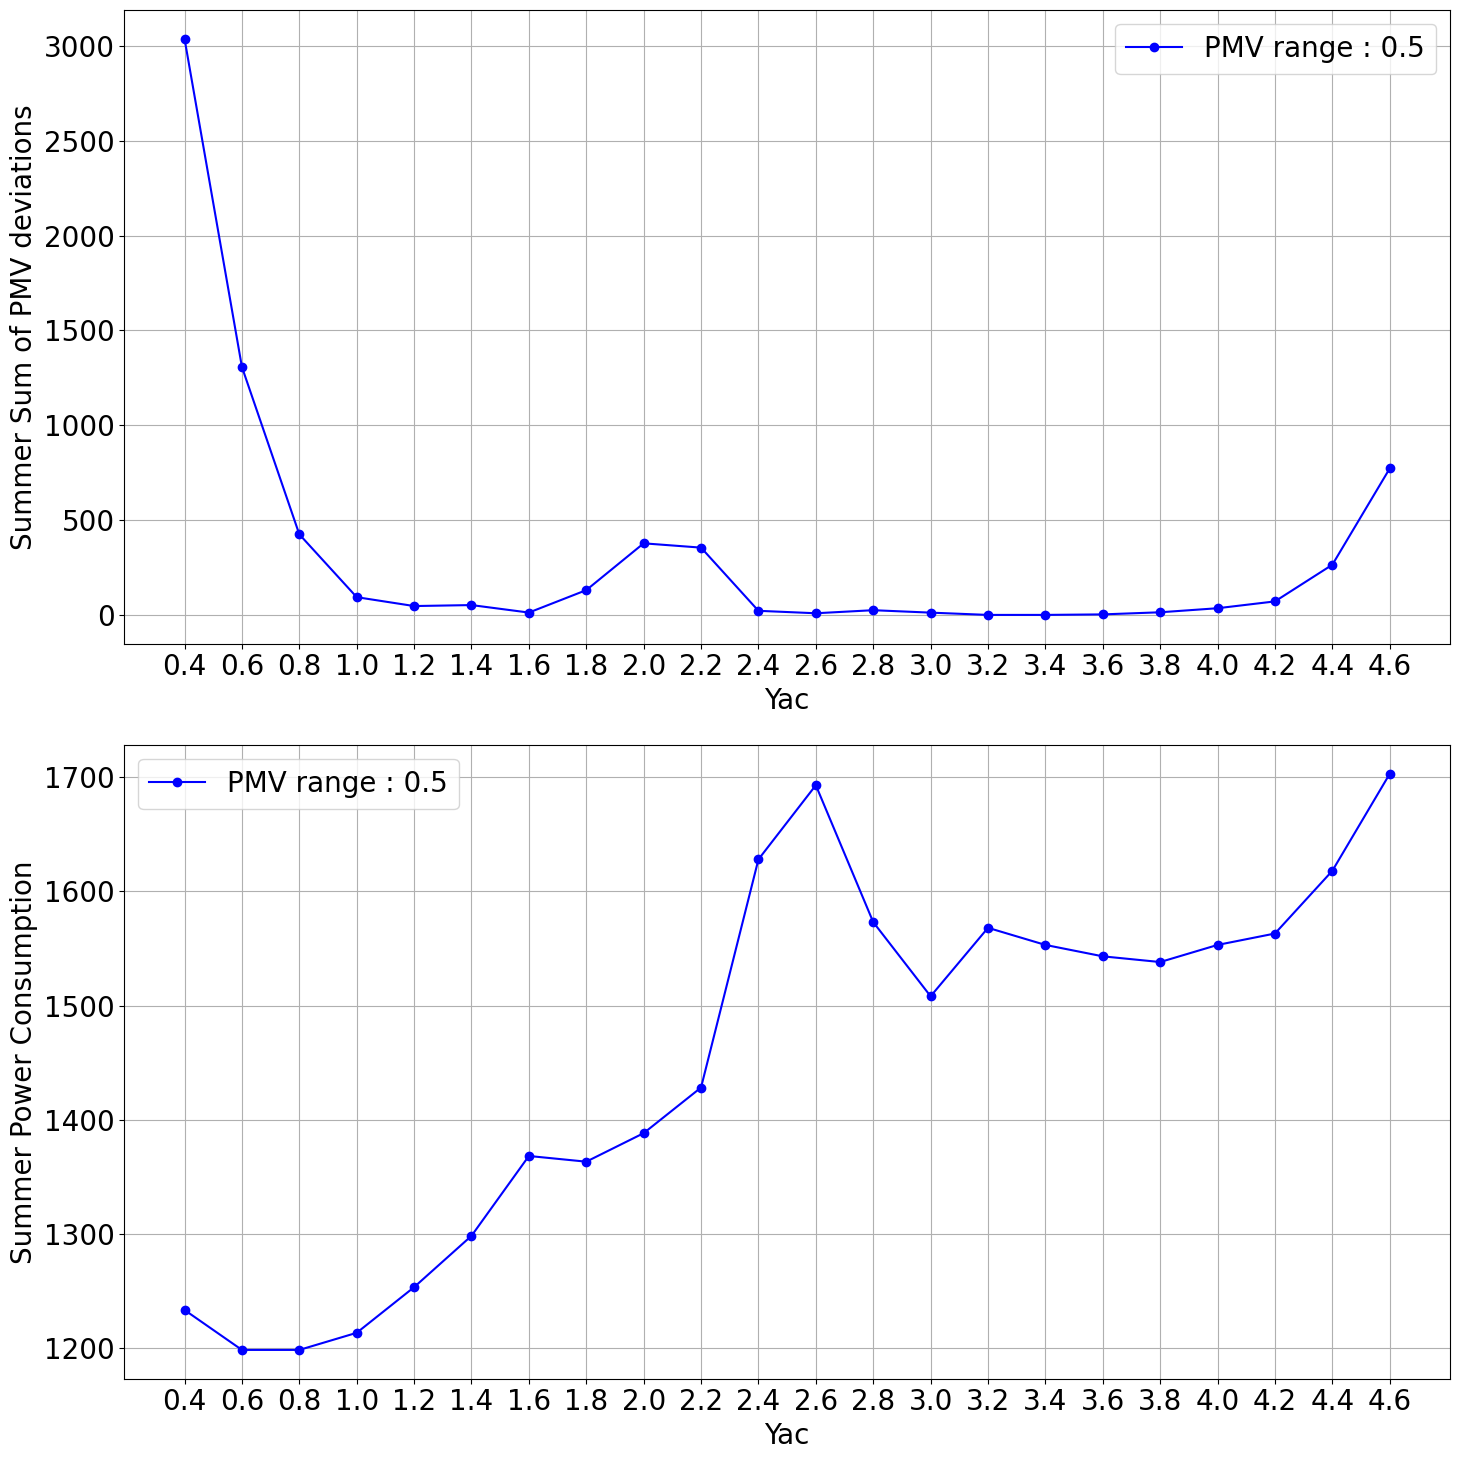

In [ ]:
plot_results(index_temp_summer, [0.5], ['b'], Yac, Q_summer, scaler_summer, model_summer, "Summer")

## Result Winter

In [ ]:
df1_winter, df2_winter = result_df_final(index_temp_winter, [0.5], Yac, Q_winter, scaler_winter, model_winter)

100%|██████████| 944/944 [50:23<00:00,  3.20s/it]


In [ ]:
indices_winter = freq(df2_winter, 'Yac = 3.8')

Most frequent value in Yac = 3.8: 341.0
Count of occurrences: 144


In [ ]:
df_calcul.iloc[indices_winter]["Sol Air Temperature"].mean()

5.3011411700128725

100%|██████████| 944/944 [27:00<00:00,  1.72s/it]


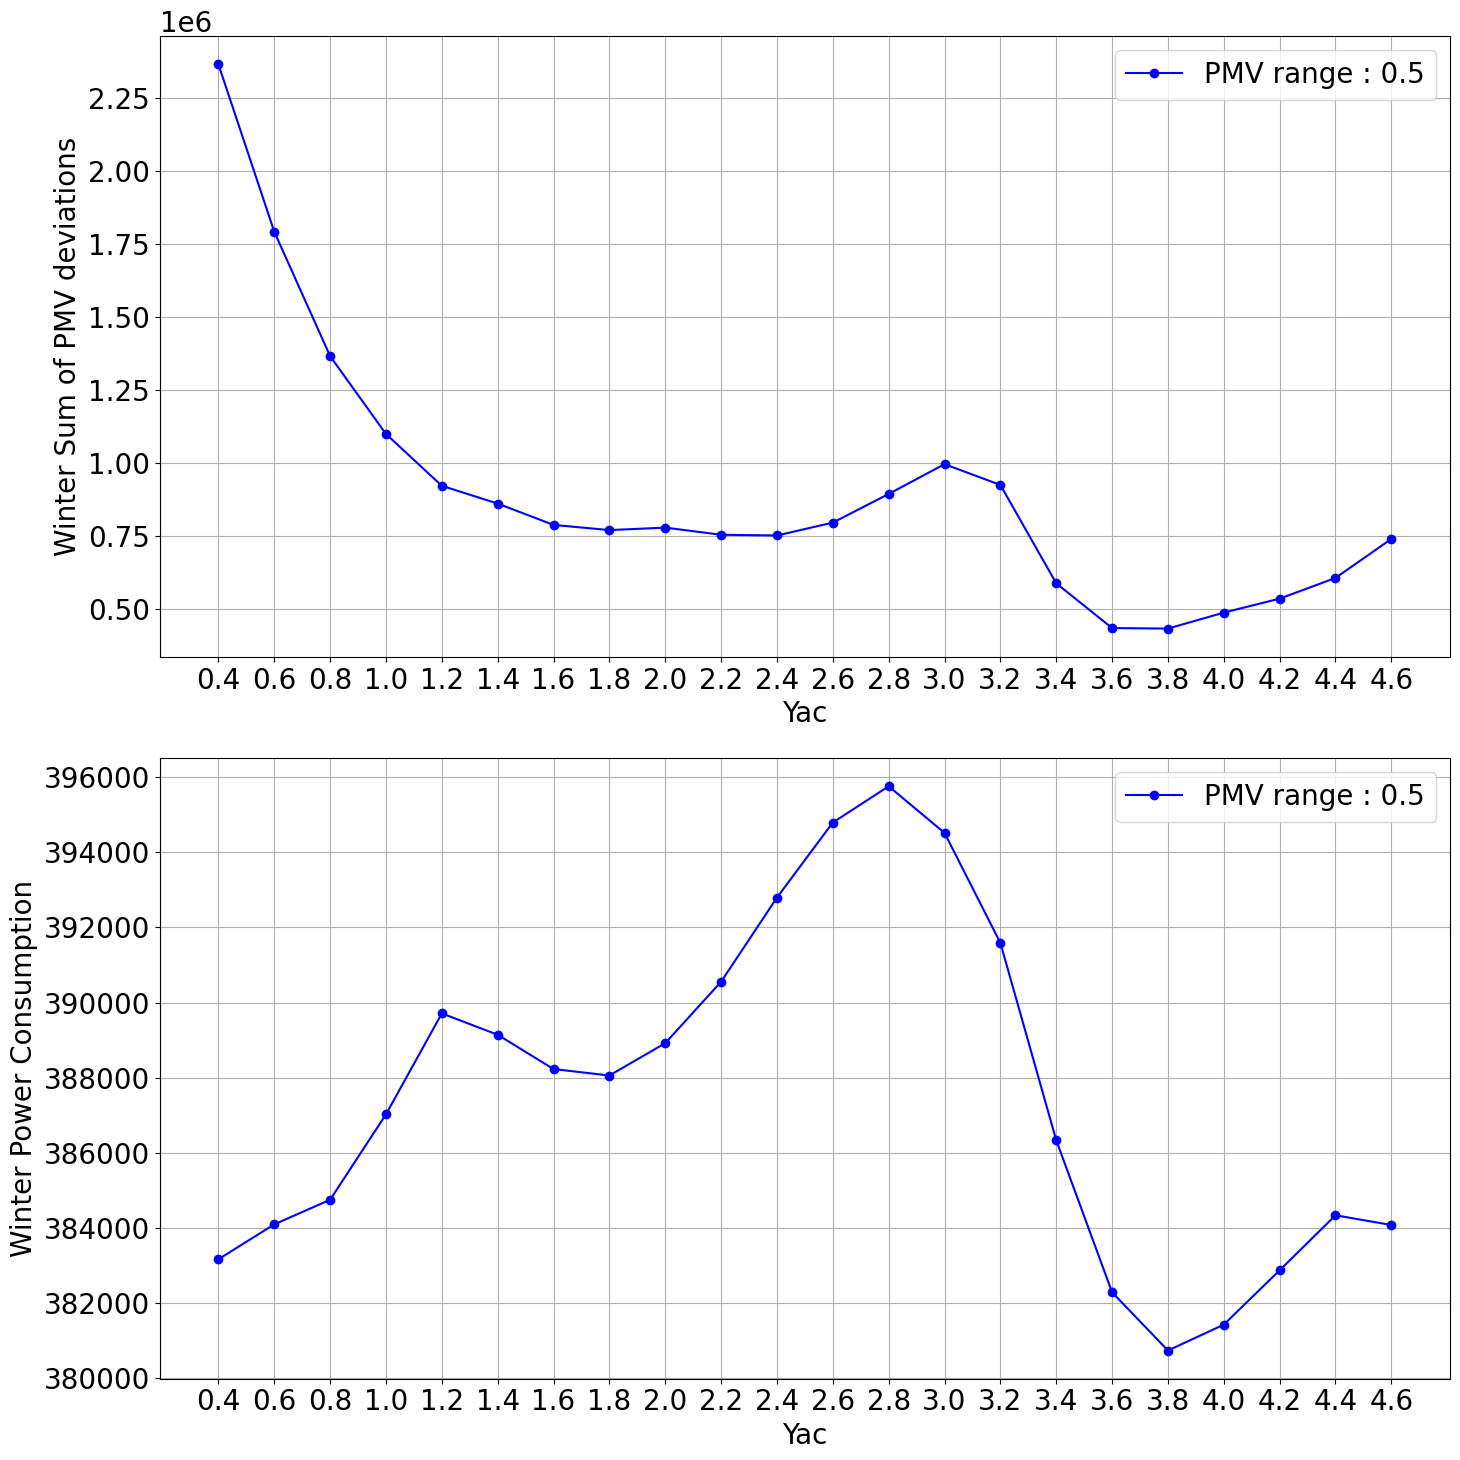

In [ ]:
plot_results(index_temp_winter, [0.5], ['b'], Yac, Q_winter, scaler_winter, model_winter, 'Winter')